In [3]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
import numpy as np
from jax import jit, random, tree_util, vmap
import jax, optax
import flax.linen as nn
import sys, os, datetime
sys.path.append(os.path.abspath('../'))
from deepmd_jax.data import SingleDataSystem
from deepmd_jax.dpmodel import DPModel
# from deepmd_jax.dpmodel import DPMPModel as DPModel
import pickle
from time import time
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, suppress=True)
print('Program start at', datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), 'on device:', jax.devices()[:1])
# Default to use 32 bit, you can change to 16 (for mixed 16/32bit) or 64 bit (not recommended)
precision      = '32' # '16' '32' '64'
if precision == '32':
    jax.config.update('jax_default_matmul_precision', 'float32')
if precision == '64':
    jax.config.update('jax_enable_x64', True)
# retina display 
%config InlineBackend.figure_format = 'retina'

env: XLA_PYTHON_CLIENT_PREALLOCATE=false
Program start at 2023-11-02 13:05:57 on device: [cuda(id=0)]


Dataset loaded: 3221 frames/384 atoms. Path: 
	'/global/u2/r/ruiqig/deepmd-jax/examples/data/polaron_val'
Lattice vectors for neighbor images: Max 1 out of 1 condidates.
Mean force error = 0.1687
Mean energy error = 0.2428, Mean energy shift = 0.6726


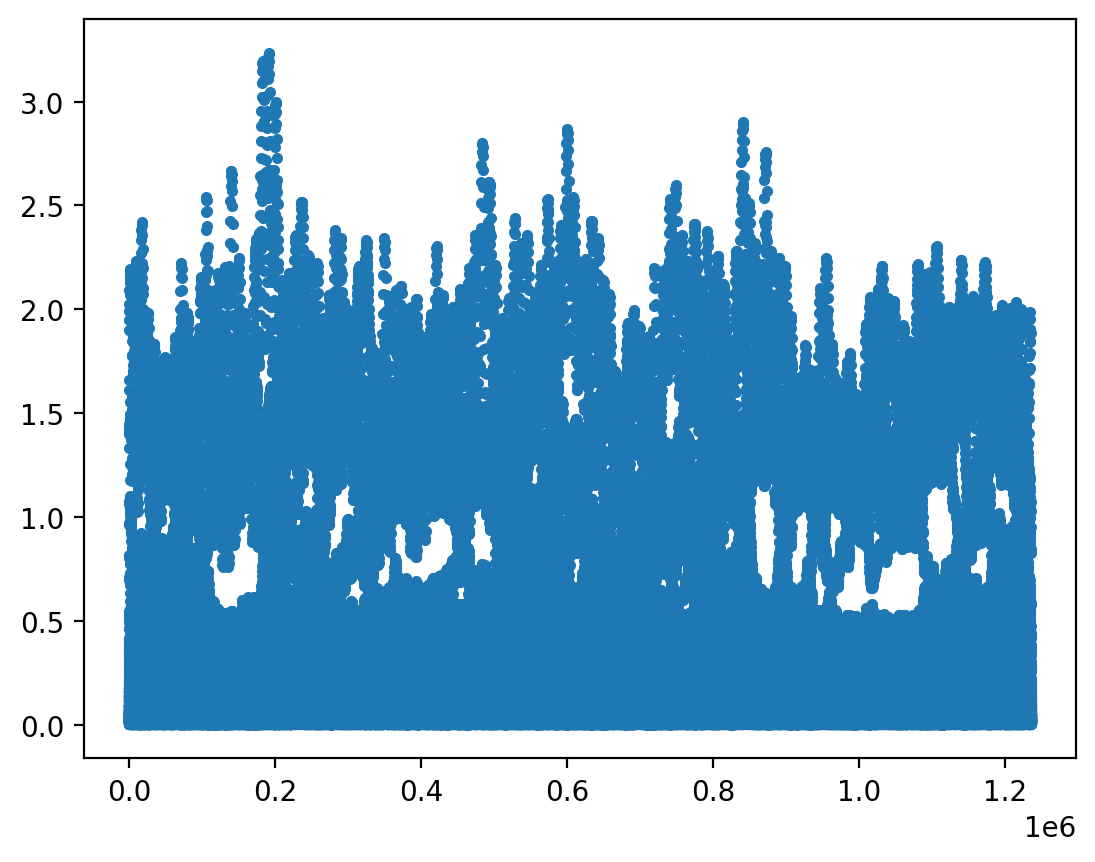

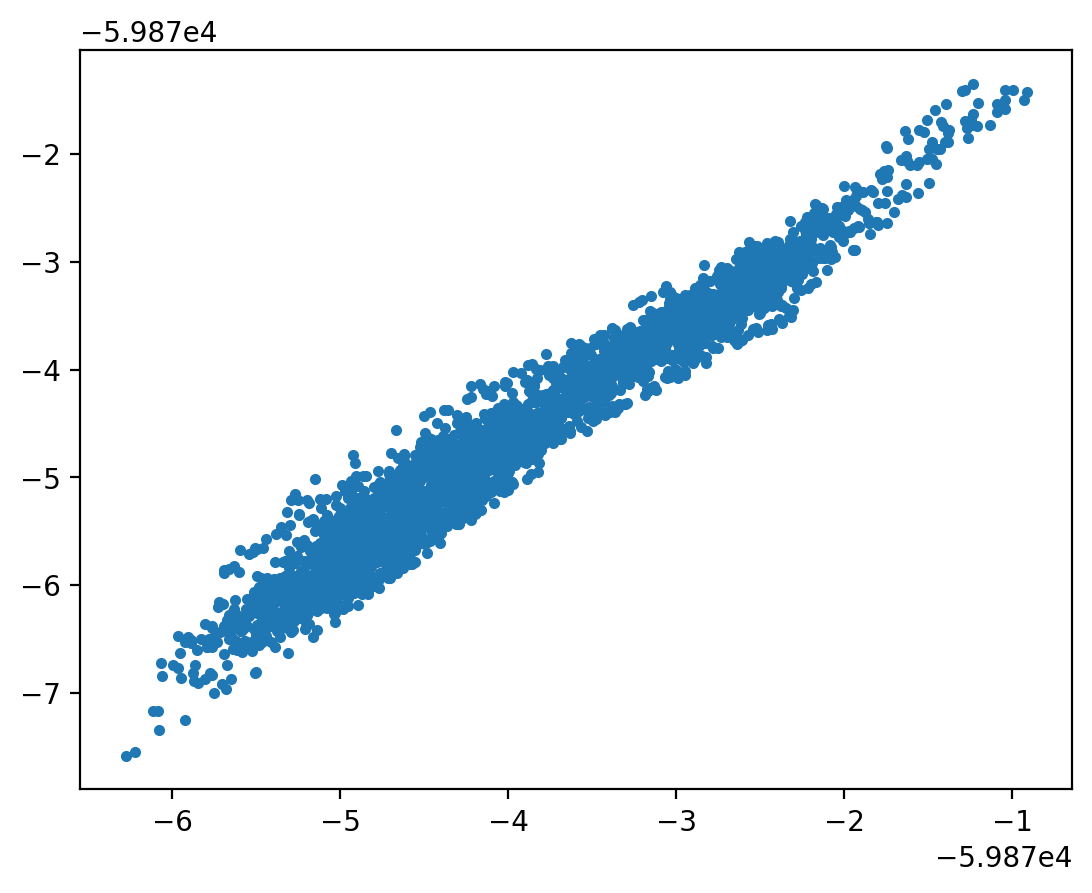

In [16]:
model_path       = 'trained_models/model_polaron_mp_final_2.pkl'
model_path       = 'trained_models/model_water_mp_final_1.pkl'
data_path        = 'data/polaron_val/'
# data_path        = '/pscratch/sd/r/ruiqig/polaron_cp2k/aimd/aimd-water/water_128_val'
test_batch_size  = 8
with open(model_path, 'rb') as file:
    m = pickle.load(file)
model, variables = m['model'], m['variables']
dataset = SingleDataSystem([data_path], ['coord', 'box', 'force', 'energy'])
dataset.compute_lattice_candidate(model.params['rcut'])
force_true, force_pred, energy_true, energy_pred = [], [], [], []
e_and_f = jit(vmap(model.energy_and_force, in_axes=(None,0,0,None)), static_argnums=(3,))
dataset.pointer = 0
for i in range(dataset.nframes//test_batch_size):
    batch, lattice_args = dataset.get_batch(test_batch_size)
    static_args = nn.FrozenDict({'lattice': lattice_args,
                            'type_idx':tuple(dataset.type_idx),
                            'ntype_idx':tuple(lattice_args['lattice_max']*dataset.type_idx)})
    force_true.append(batch['force'])
    energy_true.append(batch['energy'])
    e, f = e_and_f(variables, batch['coord'], batch['box'], static_args)
    force_pred.append(np.array(f))
    energy_pred.append(np.array(e))
force_true = np.concatenate(force_true, axis=0)
force_pred = np.concatenate(force_pred, axis=0)
energy_true = np.concatenate(energy_true, axis=0)
energy_pred = np.concatenate(energy_pred, axis=0)
force_err = force_true - force_pred
energy_err = (energy_true - energy_pred)
print('Mean force error = %.4f' % (force_err**2).mean()**0.5)
print('Mean energy error = %.4f, Mean energy shift = %.4f' % (energy_err.std(), energy_err.mean()))
# plt.plot(force_true.flatten(), force_pred.flatten(), '.') # parity plot for force
plt.figure()
plt.plot(np.abs(force_err).max(1).flatten(), '.') # max error for each atom force
plt.figure()
plt.plot(energy_true, energy_pred, '.') # parity plot for energy